In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
from reservoirpy import nodes, datasets
import hierarchical_genome_mutations_operations as hgmo
import evolution_step_functions as esf
import genome_analysis as ga
import genome_transcription as gt
import helper_functions as hf
import hierarchical_genomes as hg
import random
import copy
# Import any other necessary modules or functions you have defined in your .py files

import reservoirpy as rpy
rpy.verbosity(0)
import networkx as nx
from sklearn.metrics import mean_squared_error, mean_absolute_error


## Variables & Hyperparameters

In [17]:
n_timesteps = 2000
population_size = 50
n_generations = 50
genome_length = 100
elitism_size = 5  # Number of elites to carry over
mutation_probability = 0.1  # Probability of mutation
mutation_rate = 0.1
crossover_probability = 0.7  # Probability of crossover
crossover_rate = 0.5

# Initialize your dataset
X = datasets.mackey_glass(n_timesteps=n_timesteps, sample_len=2000)
Y = np.roll(X, -1)

# Split the dataset
train_end = int(len(X) * 0.7)
test_start = train_end + 1
X_train, Y_train = X[:train_end], Y[:train_end]
X_test, Y_test = X[test_start:], Y[test_start:]

elite_count = int(0.05 * population_size)  # 5% of the population will be elite
selected_count = 10  # The top 10 genomes to be selected



## Mutate Genome

In [3]:
def copy_mutation(genome):
    """Duplicates a random part of the genome."""
    # Example: randomly select a segment to copy
    segment_start = np.random.randint(0, len(genome))
    segment_end = np.random.randint(segment_start, len(genome))
    segment = genome[segment_start:segment_end]
    # Insert the copied segment into a random position
    insert_position = np.random.randint(0, len(genome))
    return genome[:insert_position] + segment + genome[insert_position:]

def shuffle_mutation(genome):
    """Randomly shuffles a segment of the genome."""
    segment_start = np.random.randint(0, len(genome))
    segment_end = np.random.randint(segment_start, len(genome))
    segment = genome[segment_start:segment_end]
    np.random.shuffle(segment)
    return genome[:segment_start] + segment + genome[segment_end:]

def add_mutation(genome):
    """Adds a new random element to the genome."""
    new_element = np.random.rand()  # Assuming the genome consists of numeric values
    insert_position = np.random.randint(0, len(genome))
    return genome[:insert_position] + [new_element] + genome[insert_position:]

def delete_mutation(genome):
    """Deletes a random element from the genome."""
    if len(genome) > 1:  # Ensure there's something to delete
        delete_position = np.random.randint(0, len(genome))
        return genome[:delete_position] + genome[delete_position+1:]
    return genome


# This is an example mutation function, adjust according to your implementation
def mutate_genome(genome):
    # # Apply mutations: copy, shuffle, add, delete
    # # Example of applying a copy mutation
    # genome = copy_mutation(genome)  
    # # Example of applying a shuffle mutation
    # genome = shuffle_mutation(genome) 
    # # Example of applying an add mutation
    # genome = add_mutation(genome)
    # # Example of applying a delete mutation
    # genome = delete_mutation(genome)
    # return genome
    
    # Choose a mutation type randomly for diversity
    #if random.random() < mutation_rate:
    mutation_type = random.choice([copy_mutation, shuffle_mutation, add_mutation, delete_mutation])
    mutated_genome = mutation_type(copy.deepcopy(genome))  # Deep copy for mutation
    ###print(f"Applied {mutation_type.__name__}")  # Logging for verification
    return mutated_genome


## Initialize Genome

In [4]:
def initialize_genome(genome_length):
    genome = []
    for _ in range(genome_length):
        input_node = np.random.randint(0, 10)  # Example range, adjust as needed
        output_node = np.random.randint(0, 10)  # Example range, adjust as needed
        weight = np.random.uniform(-1, 1)  # Weight range -1 to 1, adjust as needed
        genome.append((input_node, output_node, weight))
    return genome



def generate_initial_population(population_size, genome_length):
    return [initialize_genome(genome_length) for _ in range(population_size)]


## Evaluate performance

In [5]:
def evaluate_performance(true_values, predicted_values):
    # Calculate Mean Squared Error
    mse = mean_squared_error(true_values, predicted_values)
    # Calculate Root Mean Square Error
    rmse = np.sqrt(mse)
    # Calculate Mean Absolute Error
    mae = mean_absolute_error(true_values, predicted_values)
    
    return rmse, mae, mse

## Select best genomes

In [6]:
def select_best_genomes(population, fitness_scores, top_k=10):
    # Pair each genome with its fitness score
    paired_population_scores = list(zip(population, fitness_scores))
    
    # Sort the paired list by the fitness scores in descending order
    paired_population_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Select the top-k genomes
    selected_genomes = [genome for genome, score in paired_population_scores[:top_k]]
    
    return selected_genomes


## Reproduce genomes

In [7]:
def reproduce_genomes(selected_genomes, population_size):
    new_population = []
    while len(new_population) < population_size:
        # Directly use random.choice for a pure Python selection instead of np.random.choice
        parent_genome = random.choice(selected_genomes)
        
        # Ensure mutate_genome creates a proper copy of the genome for mutation
        child_genome = mutate_genome(list(copy.deepcopy(parent_genome)))  # Ensure this is a deep copy if necessary
        
        new_population.append(child_genome)
    
    return new_population


## Crossover

In [8]:
# Define a crossover function
def crossover(parent1, parent2):
    # Implementing crossover operation
    if random.random() < crossover_probability:
        crossover_point = random.randint(1, len(parent1) - 2)
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
        return child1, child2
    return parent1, parent2

    # if random.random() < crossover_rate:
    #     crossover_point = random.randint(1, len(parent1) - 2)
    #     return (parent1[:crossover_point] + parent2[crossover_point:],
    #             parent2[:crossover_point] + parent1[crossover_point:])
    # else:
    #     return parent1, parent2

## Evolutionary Loop

In [19]:



population = [initialize_genome(genome_length) for _ in range(population_size)]
    

def evaluate_genome_performance(genome, X_train, Y_train, X_test, Y_test):
    # Assuming a function to transcribe genome to weight matrix exists
    weight_matrix = gt.transcribe_hierarchical_genome_to_weight_matrix(genome)
    esn = setup_esn(weight_matrix)
    esn.fit(X_train, Y_train)
    predicted = esn.run(X_test)
    rmse, mae, mse = evaluate_performance(Y_test, predicted)
    return rmse, mae, mse


def setup_esn(weight_matrix, input_dim=1, spectral_radius=0.9, ridge=1e-6):
    num_reservoir_nodes = weight_matrix.shape[0]
    
    esn = nodes.Reservoir(
        Win=np.ones((num_reservoir_nodes, input_dim)),  # Input weight matrix
        W=weight_matrix,                                # Internal weight matrix
        bias=np.zeros((num_reservoir_nodes, 1))
    ) >> nodes.Ridge(ridge=ridge)                      # Readout layer with ridge regression
    
    return esn


# Generate the initial population
#population = generate_initial_population(population_size, genome_length)
fitness_scores = []
rmse_scores_over_generations = []
mae_scores_over_generations = []
mse_scores_over_generations = []
best_weight_matrices = []


#v2  
for generation in range(n_generations):
    new_fitness_scores = []
    new_mae_scores = []
    new_mse_scores = []
    
    # for current_end in range(1, n_timesteps):  # Ensuring we always have at least 1 sample for testing
    #     # Adjust the training and testing dataset according to the current timestep
    #     X_train, Y_train = X[:current_end], Y[:current_end]
    #     X_test, Y_test = X[current_end:], Y[current_end:]

    #     # Skip the loop iteration if there are not enough samples for either training or testing
    #     if len(X_train) < 1 or len(X_test) < 1:
    #         continue
    
        
    # Mutate, evaluate, and select genomes
    for genome in population:
        #if random.random() < mutation_probability:
        genome = mutate_genome(genome)
        rmse, mae, mse = evaluate_genome_performance(genome, X_train, Y_train, X_test, Y_test)
        new_fitness_scores.append(rmse)
        new_mae_scores.append(mae)
        new_mse_scores.append(mse)
    
    # if current_end % 100 == 0 or current_end == n_timesteps - 1:  # Adjusted to avoid empty test sets
    #     print(f"Step: {current_end}")


    # Update fitness scores and select best genomes
    fitness_scores = new_fitness_scores
    best_indices = np.argsort(fitness_scores)[:10]
    selected_genomes = [population[i] for i in best_indices]
    #selected_genomes = select_best_genomes(population, fitness_scores, top_k=10)
    
    # Diversity preservation by selecting a mix of best and random genomes
    # sorted_genomes = sorted(zip(population, new_fitness_scores), key=lambda x: x[1])
    # top_genomes = [genome for genome, score in sorted_genomes[:int(population_size * 0.2)]]
    # random_genomes = [genome for genome, score in sorted_genomes[int(population_size * 0.2):]]
    # selected_genomes = top_genomes + random.sample(random_genomes, population_size - len(top_genomes))

    
    # Reproduce genomes
    #population = [mutate_genome(random.choice(selected_genomes)) for _ in range(population_size)]
    population = reproduce_genomes(selected_genomes, population_size)
    
    
    rmse_scores_over_generations.append(min(fitness_scores))
    mae_scores_over_generations.append(min(new_mae_scores))
    mse_scores_over_generations.append(min(new_mse_scores))
    print(f"Generation {generation}: Best RMSE Score: {min(fitness_scores)}, Best MAE Score: {min(new_mae_scores)}, Best MSE Score: {min(new_mse_scores)}")
    #print(f"Generation {generation}: Best RMSE={min(fitness_scores)}")
    
    best_genome = selected_genomes[0]
    best_weight_matrix = gt.transcribe_hierarchical_genome_to_weight_matrix(best_genome)
    best_weight_matrices.append(best_weight_matrix)




Step 1999: Current Best RMSE=0.3848791170924547
Generation 0: Best RMSE Score: 0.3848791170924547, Best MAE Score: 0.3848791170924547, Best MSE Score: 0.14813193477386746
Step 1999: Current Best RMSE=0.3848791170924547
Generation 1: Best RMSE Score: 0.3848791170924547, Best MAE Score: 0.3848791170924547, Best MSE Score: 0.14813193477386746
Step 1999: Current Best RMSE=0.25466961257393694
Generation 2: Best RMSE Score: 0.25466961257393694, Best MAE Score: 0.25466961257393694, Best MSE Score: 0.06485661156855914
Step 1999: Current Best RMSE=0.25466961257393694
Generation 3: Best RMSE Score: 0.25466961257393694, Best MAE Score: 0.25466961257393694, Best MSE Score: 0.06485661156855914
Step 1999: Current Best RMSE=0.25466961257393694
Generation 4: Best RMSE Score: 0.25466961257393694, Best MAE Score: 0.25466961257393694, Best MSE Score: 0.06485661156855914
Step 1999: Current Best RMSE=0.25466961257393694
Generation 5: Best RMSE Score: 0.25466961257393694, Best MAE Score: 0.25466961257393694

KeyboardInterrupt: 

## Scores over generations

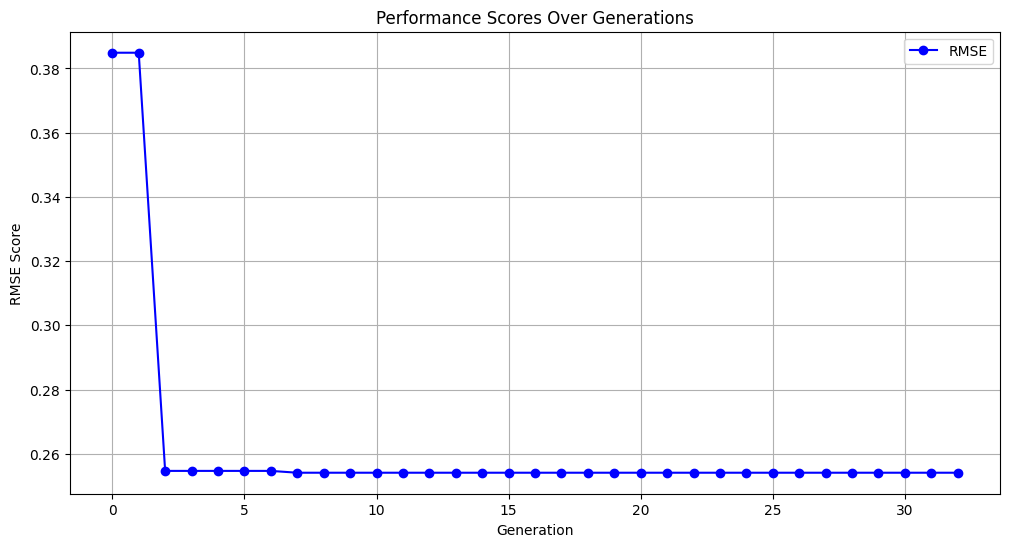

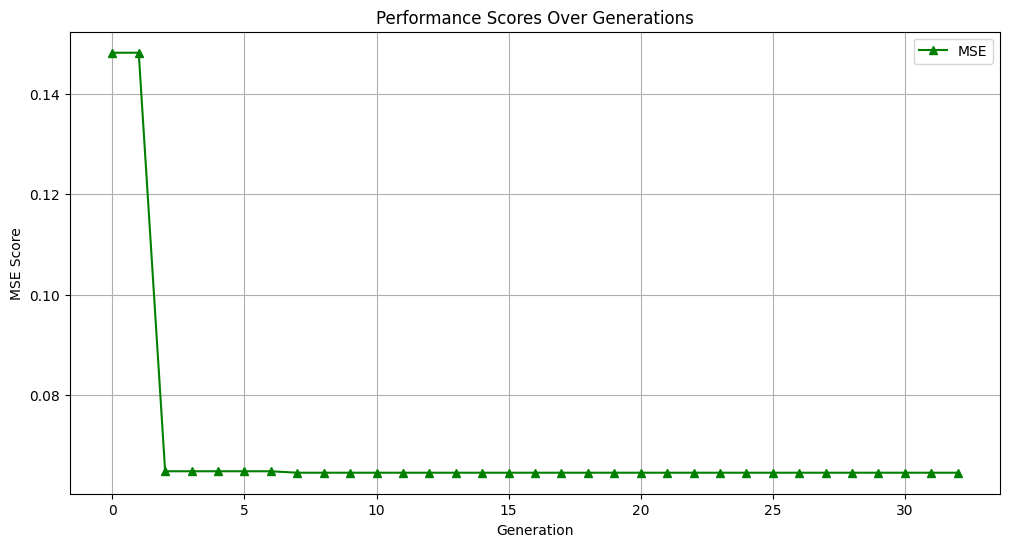

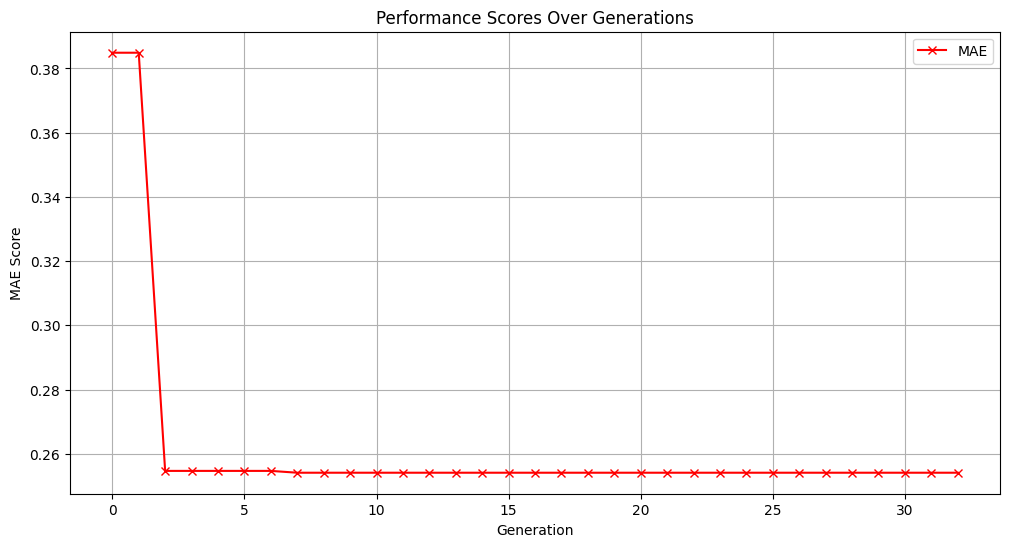

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(rmse_scores_over_generations, marker='o', linestyle='-', color='b', label='RMSE')
#plt.plot(mae_scores_over_generations, marker='x', linestyle='-', color='r', label='MAE')
#plt.plot(mse_scores_over_generations, marker='^', linestyle='-', color='g', label='MSE')
plt.title('Performance Scores Over Generations')
plt.xlabel('Generation')
plt.ylabel('RMSE Score')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
#plt.plot(rmse_scores_over_generations, marker='o', linestyle='-', color='b', label='RMSE')
#plt.plot(mae_scores_over_generations, marker='x', linestyle='-', color='r', label='MAE')
plt.plot(mse_scores_over_generations, marker='^', linestyle='-', color='g', label='MSE')
plt.title('Performance Scores Over Generations')
plt.xlabel('Generation')
plt.ylabel('MSE Score')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
#plt.plot(rmse_scores_over_generations, marker='o', linestyle='-', color='b', label='RMSE')
plt.plot(mae_scores_over_generations, marker='x', linestyle='-', color='r', label='MAE')
#plt.plot(mse_scores_over_generations, marker='^', linestyle='-', color='g', label='MSE')
plt.title('Performance Scores Over Generations')
plt.xlabel('Generation')
plt.ylabel('MAE Score')
plt.legend()
plt.grid(True)
plt.show()

##  Plotting the weight matrices

In [ ]:
# Now plot the weight matrices
fig, axes = plt.subplots(len(best_weight_matrices), 1, figsize=(10, len(best_weight_matrices)*5))
for i, weight_matrix in enumerate(best_weight_matrices):
    ax = axes[i]
    weight_matrix = np.abs(weight_matrix)
    weight_matrix += weight_matrix != 0

    graph = nx.from_numpy_array(weight_matrix, create_using=nx.DiGraph)
    nx.draw_kamada_kawai(graph, ax=ax, with_labels=True)
    ax.set_title(f"Generation {i} Weight Matrix")

plt.tight_layout()
plt.show()